In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
seed = 42
np.random.seed(seed=seed)
from statsmodels.tsa.stattools import kpss, adfuller
warnings.simplefilter("ignore")

In [2]:
train_df = pd.read_csv('/kaggle/input/playground-series-s5e1/train.csv')
test_df = pd.read_csv('/kaggle/input/playground-series-s5e1/test.csv')

In [3]:
train_df.shape

(230130, 6)

In [4]:
train_df.isna().sum(), test_df.isna().sum()

(id             0
 date           0
 country        0
 store          0
 product        0
 num_sold    8871
 dtype: int64,
 id         0
 date       0
 country    0
 store      0
 product    0
 dtype: int64)

In [5]:
train_df.isna().sum().sum() * 100 / train_df.shape[0]

3.854777734324078

Видим, что количество пропусков в процентном соотношении достаточно мало, поэтому можем удалить строчки, содержащие пропуски

In [6]:
train_df.dropna(inplace=True)

In [7]:
train_df.isna().sum(), train_df.shape

(id          0
 date        0
 country     0
 store       0
 product     0
 num_sold    0
 dtype: int64,
 (221259, 6))

In [8]:
train_df.head()

,id,date,country,store,product,num_sold
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0
5,5,2010-01-01,Canada,Stickers for Less,Holographic Goose,300.0


In [9]:
from sklearn.preprocessing import LabelEncoder
enc = LabelEncoder()

In [10]:
train_df.date = enc.fit_transform(train_df.date)

In [11]:
train_df

,id,date,country,store,product,num_sold
1,1,0,Canada,Discount Stickers,Kaggle,973.0
2,2,0,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,0,Canada,Discount Stickers,Kerneler,423.0
4,4,0,Canada,Discount Stickers,Kerneler Dark Mode,491.0
5,5,0,Canada,Stickers for Less,Holographic Goose,300.0
...,...,...,...,...,...,...
230125,230125,2556,Singapore,Premium Sticker Mart,Holographic Goose,466.0
230126,230126,2556,Singapore,Premium Sticker Mart,Kaggle,2907.0
230127,230127,2556,Singapore,Premium Sticker Mart,Kaggle Tiers,2299.0
230128,230128,2556,Singapore,Premium Sticker Mart,Kerneler,1242.0


<Axes: xlabel='Count', ylabel='country'>

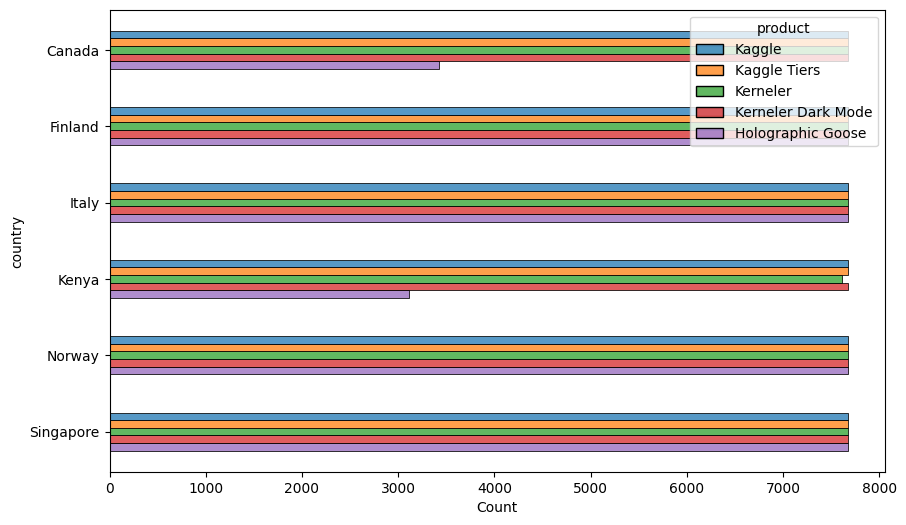

In [12]:
plt.figure(figsize=(10,6))
sns.histplot(data = train_df, y='country', hue='product', multiple='dodge', shrink=.5)

<Axes: xlabel='Count', ylabel='product'>

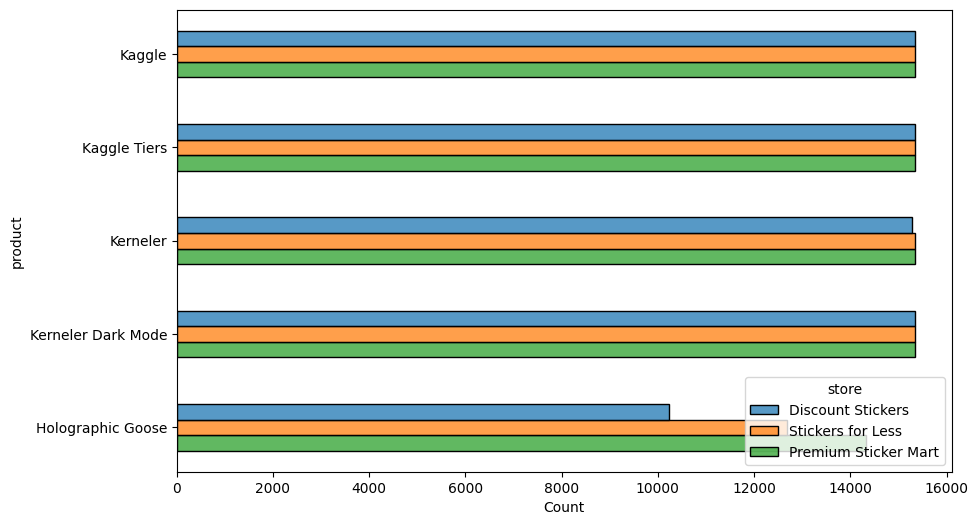

In [14]:
plt.figure(figsize=(10,6))
sns.histplot(data = train_df, y='product', hue='store', multiple='dodge', shrink=.5)

<Axes: xlabel='Count', ylabel='country'>

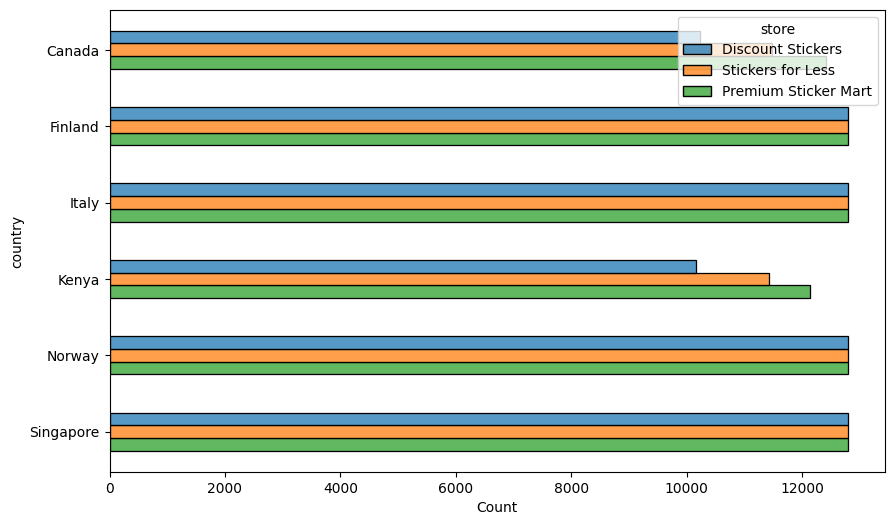

In [15]:
plt.figure(figsize=(10,6))
sns.histplot(data = train_df, y='country', hue='store', multiple='dodge', shrink=.5)

In [16]:
train_kaggle = train_df.query('product == "Kaggle"')
train_kaggle.head(), train_kaggle.shape

(    id  date  country                 store product  num_sold
 1    1     0   Canada     Discount Stickers  Kaggle     973.0
 6    6     0   Canada     Stickers for Less  Kaggle    1837.0
 11  11     0   Canada  Premium Sticker Mart  Kaggle    2212.0
 16  16     0  Finland     Discount Stickers  Kaggle     926.0
 21  21     0  Finland     Stickers for Less  Kaggle    1948.0,
 (46026, 6))

In [17]:
train_kaggle_tiers = train_df.query('product == "Kaggle Tiers"')
train_kaggle_tiers.head(), train_kaggle_tiers.shape

(    id  date  country                 store       product  num_sold
 2    2     0   Canada     Discount Stickers  Kaggle Tiers     906.0
 7    7     0   Canada     Stickers for Less  Kaggle Tiers    1659.0
 12  12     0   Canada  Premium Sticker Mart  Kaggle Tiers    2013.0
 17  17     0  Finland     Discount Stickers  Kaggle Tiers     774.0
 22  22     0  Finland     Stickers for Less  Kaggle Tiers    1632.0,
 (46026, 6))

In [18]:
train_kerneler = train_df.query('product == "Kerneler"')
train_kerneler.head(), train_kerneler.shape

(    id  date  country                 store   product  num_sold
 3    3     0   Canada     Discount Stickers  Kerneler     423.0
 8    8     0   Canada     Stickers for Less  Kerneler     807.0
 13  13     0   Canada  Premium Sticker Mart  Kerneler     950.0
 18  18     0  Finland     Discount Stickers  Kerneler     424.0
 23  23     0  Finland     Stickers for Less  Kerneler     878.0,
 (45962, 6))

In [19]:
train_kerneler_dm = train_df.query('product == "Kerneler Dark Mode"')
train_kerneler_dm.head(), train_kerneler_dm.shape

(    id  date  country                 store             product  num_sold
 4    4     0   Canada     Discount Stickers  Kerneler Dark Mode     491.0
 9    9     0   Canada     Stickers for Less  Kerneler Dark Mode     940.0
 14  14     0   Canada  Premium Sticker Mart  Kerneler Dark Mode    1213.0
 19  19     0  Finland     Discount Stickers  Kerneler Dark Mode     450.0
 24  24     0  Finland     Stickers for Less  Kerneler Dark Mode     950.0,
 (46025, 6))

In [20]:
train_holographic_goose = train_df.query('product == "Holographic Goose"')
train_holographic_goose, train_holographic_goose.shape

(            id  date    country                 store            product  \
 5            5     0     Canada     Stickers for Less  Holographic Goose   
 10          10     0     Canada  Premium Sticker Mart  Holographic Goose   
 15          15     0    Finland     Discount Stickers  Holographic Goose   
 20          20     0    Finland     Stickers for Less  Holographic Goose   
 25          25     0    Finland  Premium Sticker Mart  Holographic Goose   
 ...        ...   ...        ...                   ...                ...   
 230105  230105  2556     Norway     Stickers for Less  Holographic Goose   
 230110  230110  2556     Norway  Premium Sticker Mart  Holographic Goose   
 230115  230115  2556  Singapore     Discount Stickers  Holographic Goose   
 230120  230120  2556  Singapore     Stickers for Less  Holographic Goose   
 230125  230125  2556  Singapore  Premium Sticker Mart  Holographic Goose   
 
         num_sold  
 5          300.0  
 10         375.0  
 15         15

Воспользуемся несколькими подходами к прогнозированию временных рядов: Моделями ARIMA/SARIMA и методами машинного обучения

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
train_df_kaggle, valid_df_kaggle = pd.DataFrame(), pd.DataFrame()

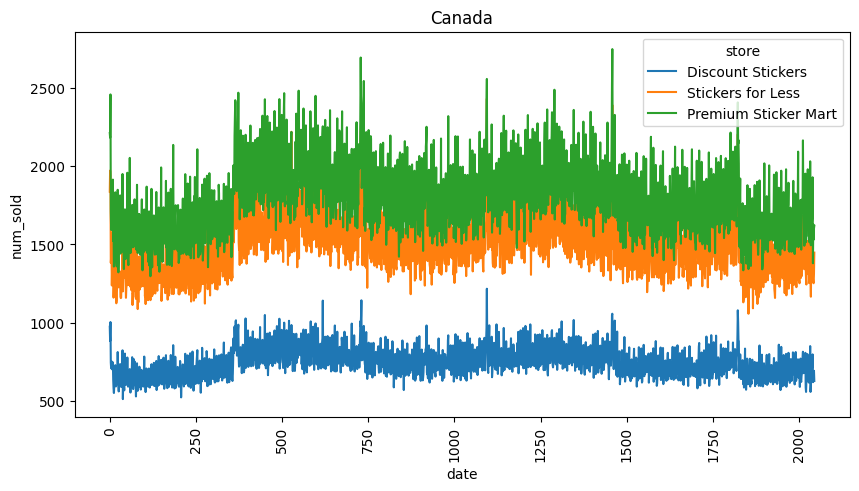

0.01 0.19414409063997906


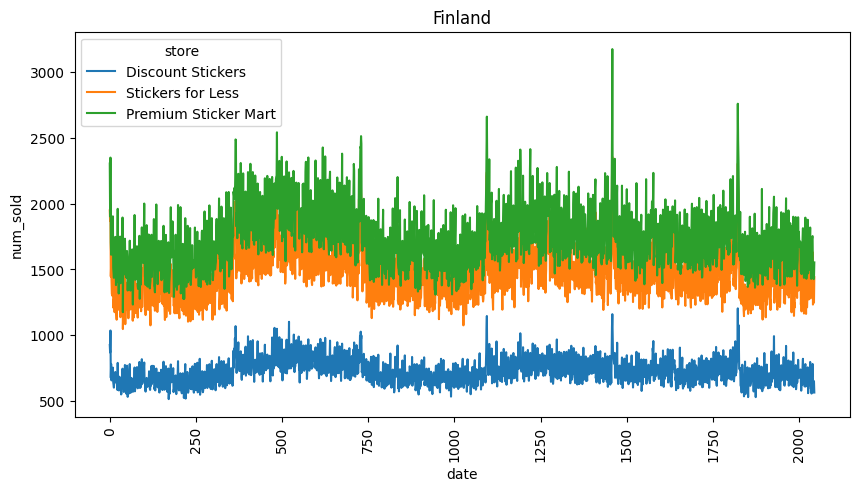

0.01 0.04674483973428432


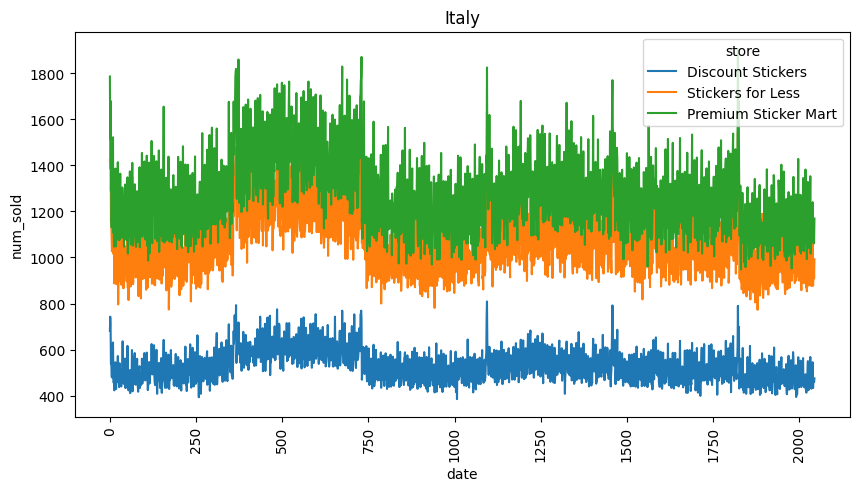

0.01 0.10905787723151245


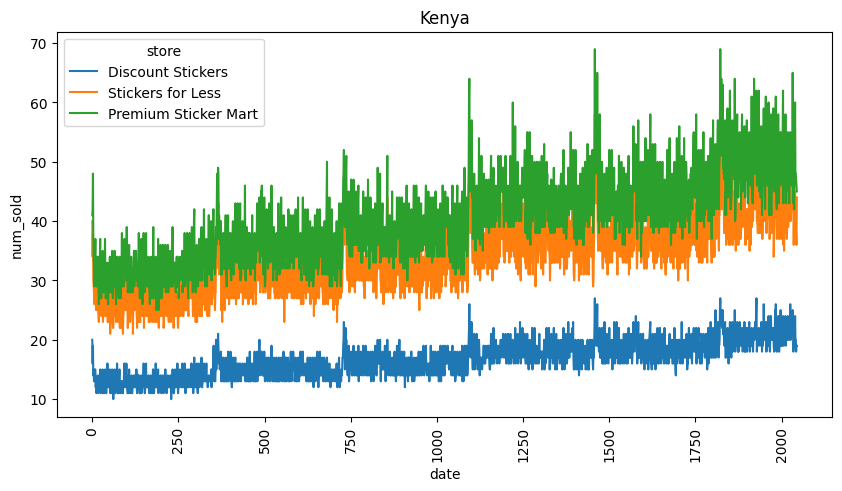

0.01 0.8277577559822911


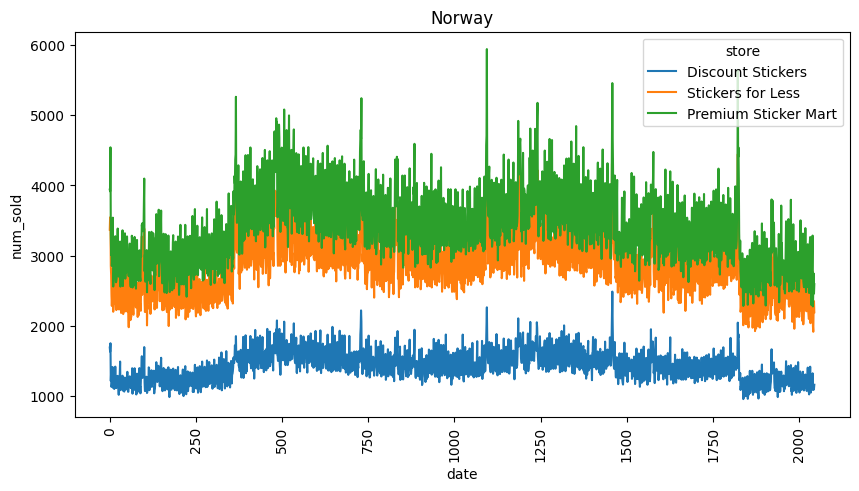

0.01 0.42828906917392773


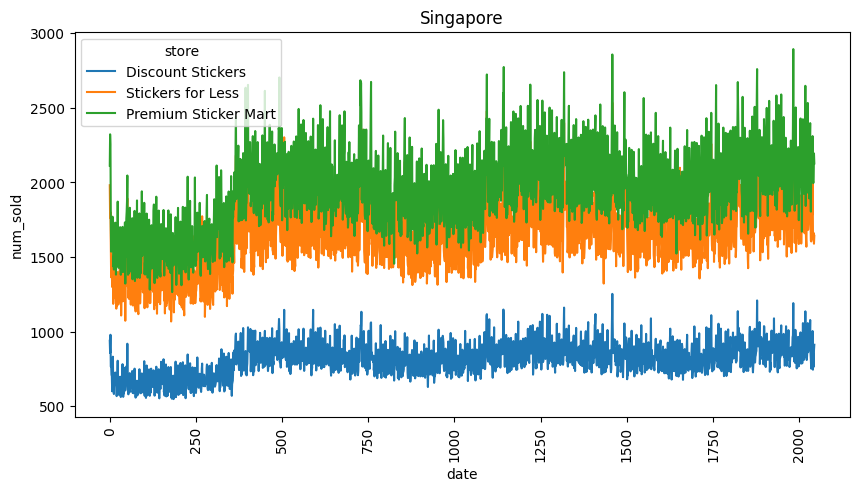

0.01 0.1982363964848219


In [23]:
for country in train_kaggle.country.unique():
    plt.figure(figsize=(10, 5))
    for store in train_kaggle.store.unique():
        temp = train_kaggle.query('store == @store & country == @country')
        temp_train, temp_valid = train_test_split(temp, test_size=0.2, shuffle=False)
        train_df_kaggle, valid_df_kaggle = pd.concat([train_df_kaggle, temp_train]), pd.concat([valid_df_kaggle, temp_valid])
    sns.lineplot(data=train_df_kaggle.query('country == @country'), x='date', y='num_sold', hue='store')
    plt.title(country)
    plt.xticks(rotation=90)
    plt.show()
    print(kpss(temp.num_sold)[1], adfuller(temp.num_sold)[1])

<b>Так как все ряды нестационарны по двум тестам, будем искать порядок дифференцирования для модели ARIMA при котором ряды каждый из отдельных рядов станет стационарным</b>

In [25]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

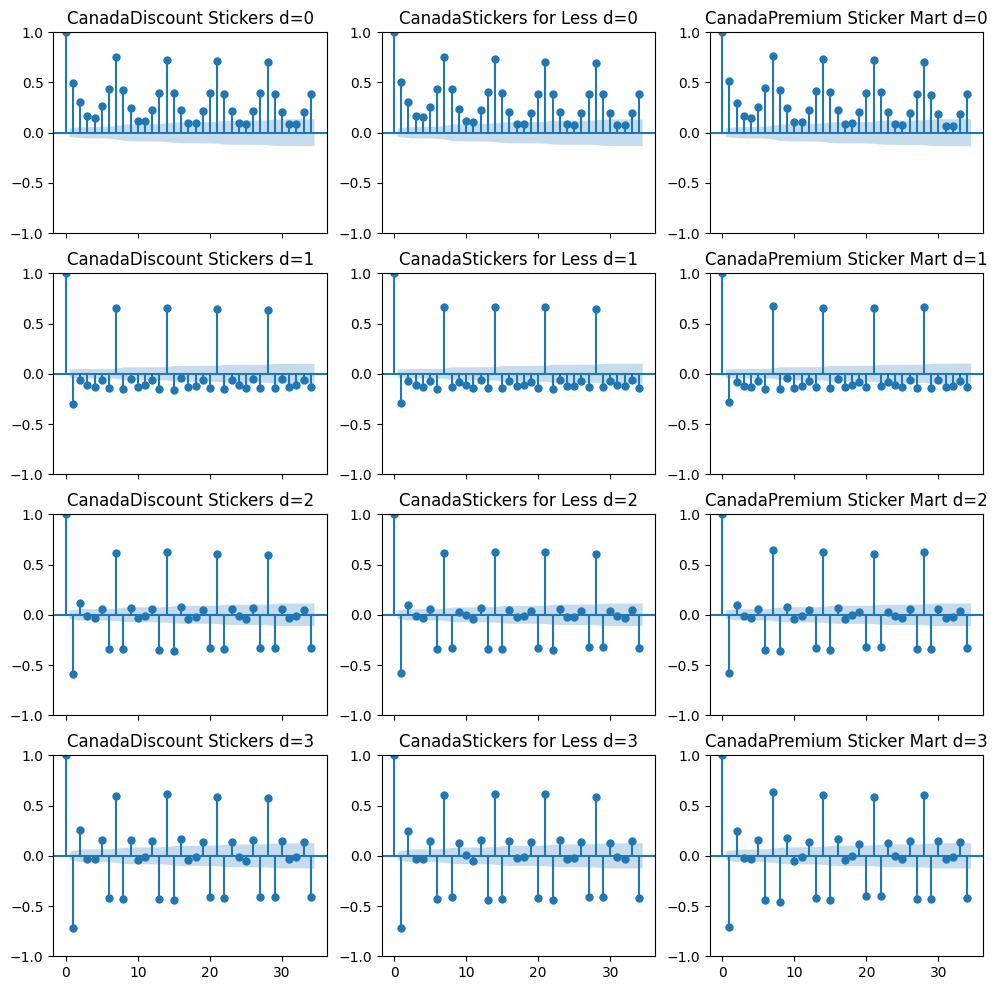

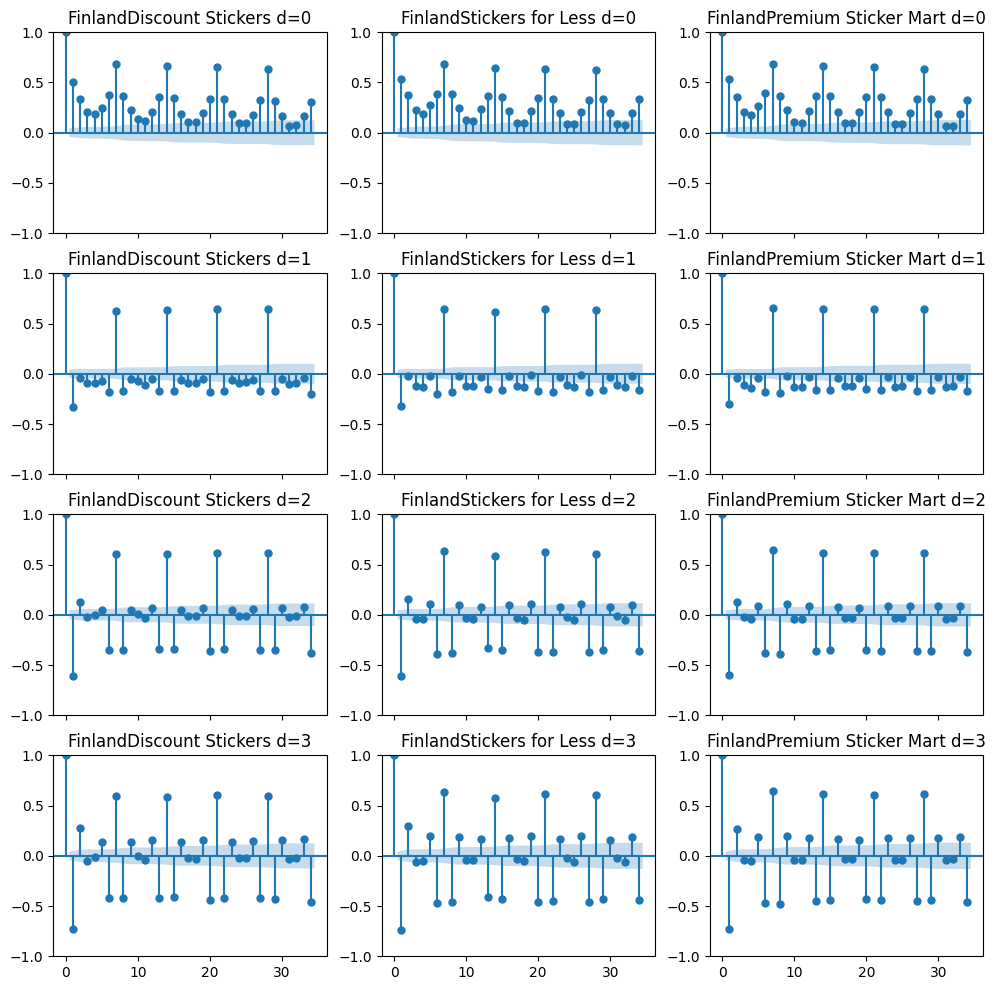

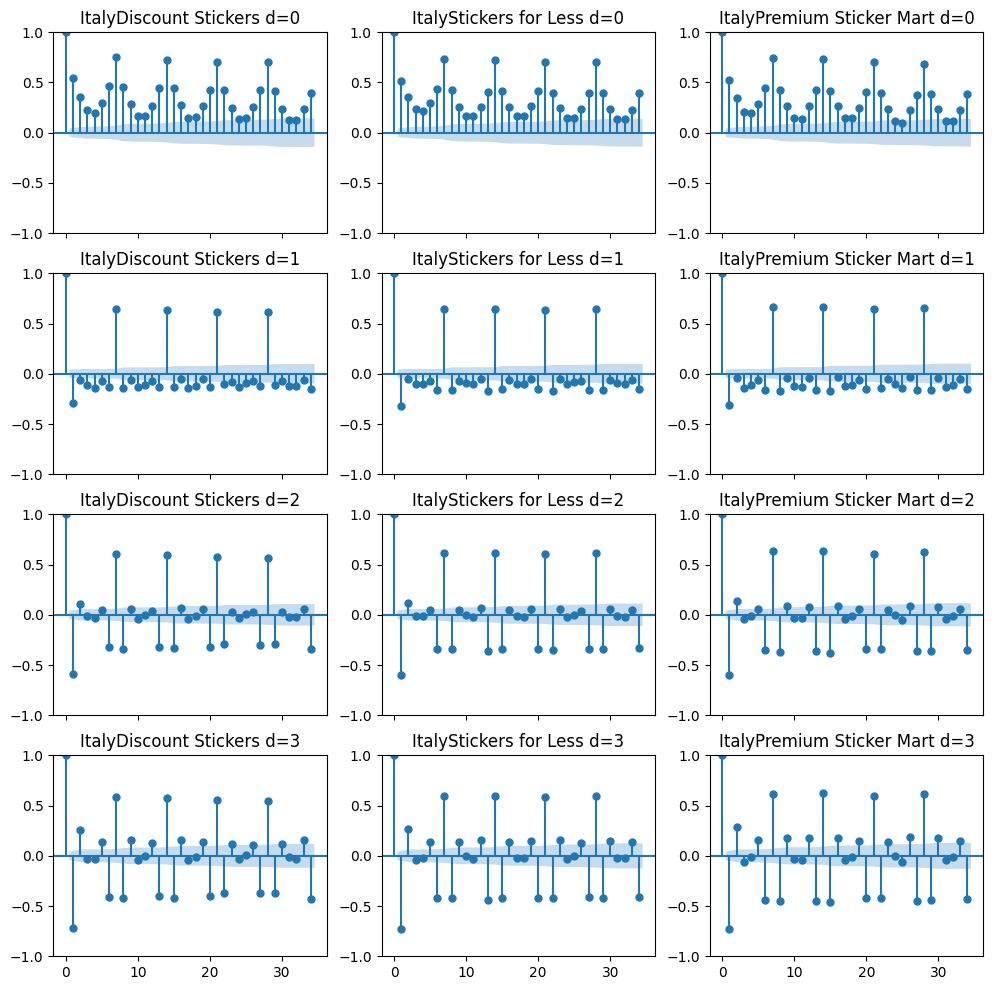

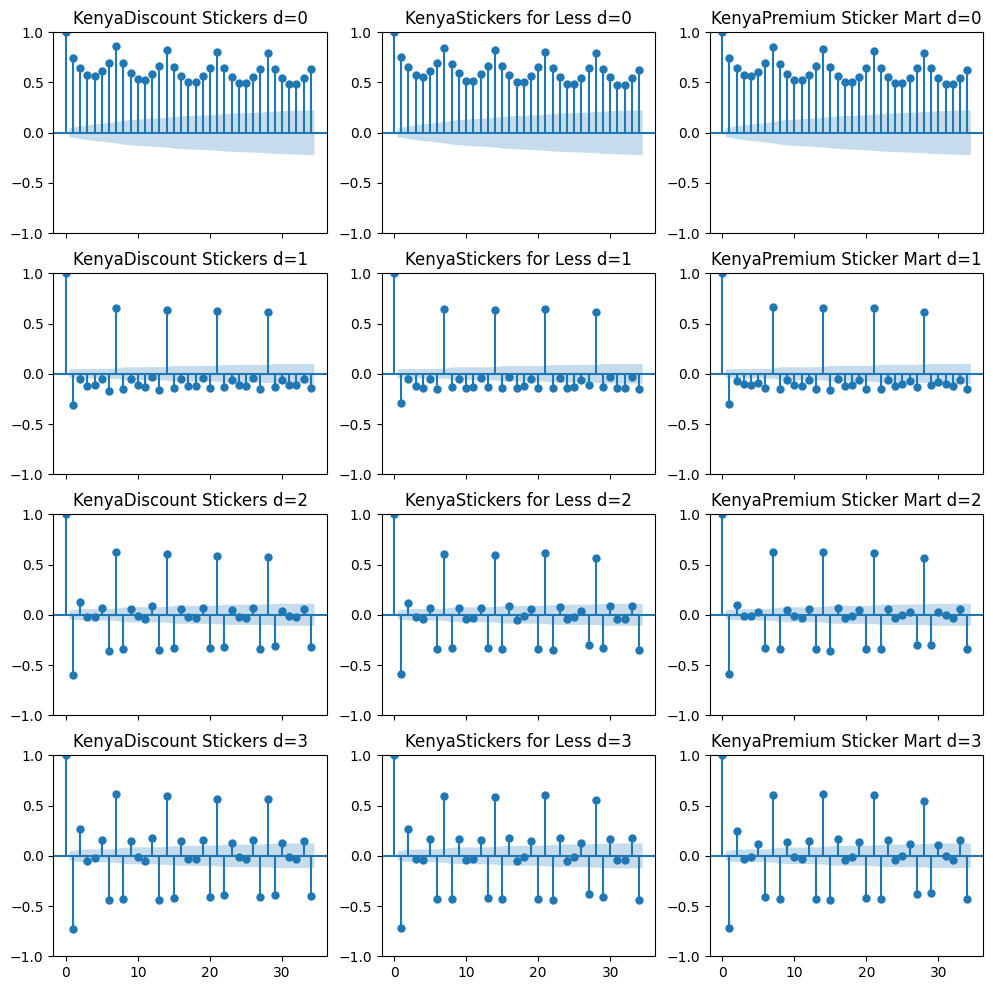

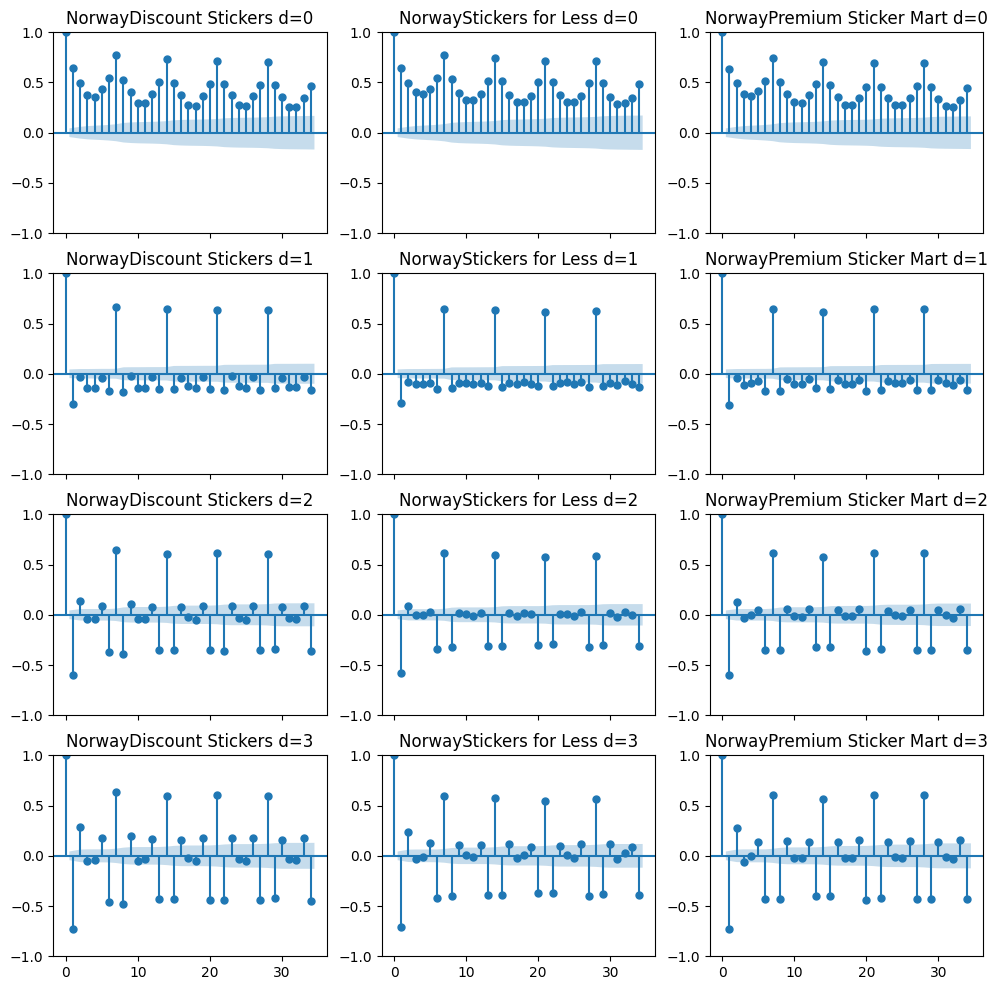

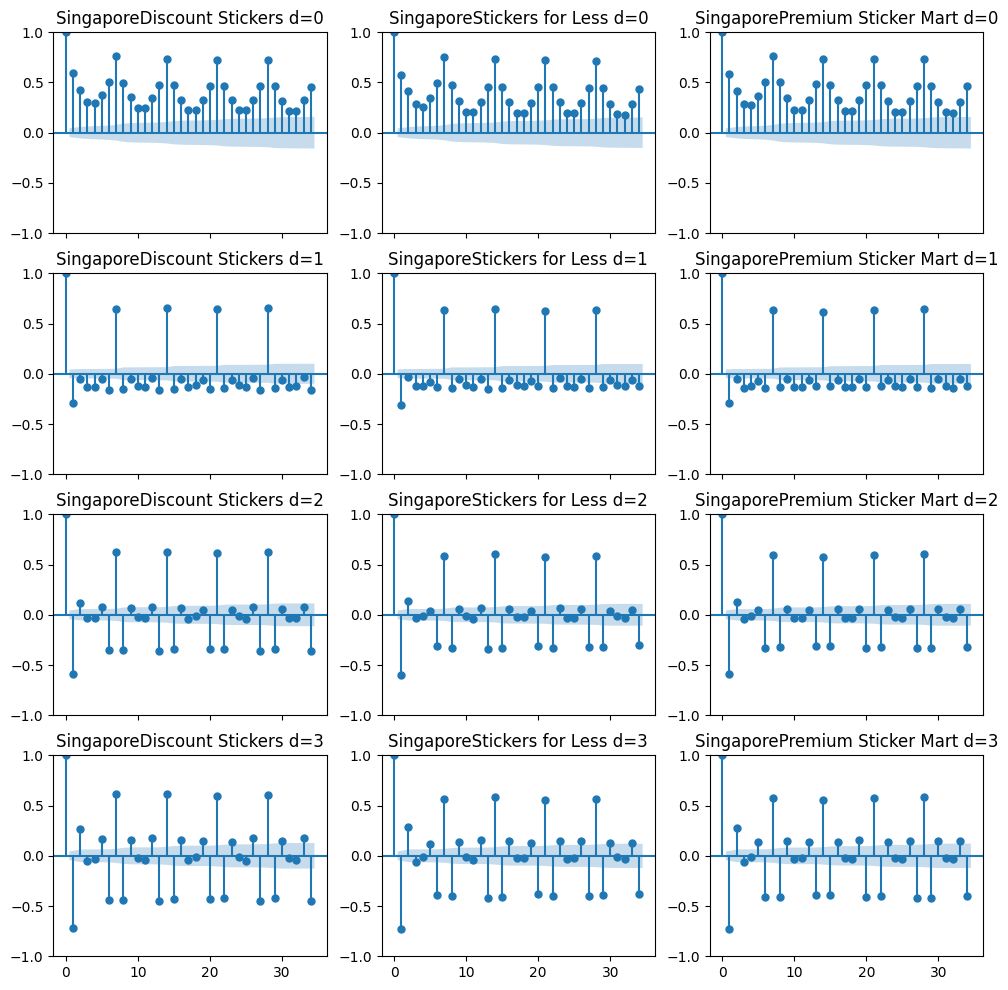

In [26]:
for country in train_kaggle.country.unique():
    fig, axes = plt.subplots(4, 3, sharex=True, figsize=(12, 12))
    i = 0
    for store in train_kaggle.store.unique():
        temp = train_df_kaggle.query('country == @country & store == @store')
        # Original Series
        plot_acf(temp.num_sold, ax=axes[0, i//3], title=country + store +' d=0')
        
        # 1st Differencing
        plot_acf(temp.num_sold.diff().dropna(), ax=axes[1, i//3], title=country + store +' d=1')
        
        # 2nd Differencing
        plot_acf(temp.num_sold.diff().diff().dropna(), ax=axes[2, i//3], title=country + store +' d=2')
    
        # 3nd Differencing
        plot_acf(temp.num_sold.diff().diff().diff().dropna(), ax=axes[3,i//3], title=country + store +' d=3')
        i += 3
    plt.show()

По графикам ACF видно, что в целом для каждой страны достаточно брать порядок дифференцирования равный 2.
Далее необходимо определить порядок AR части

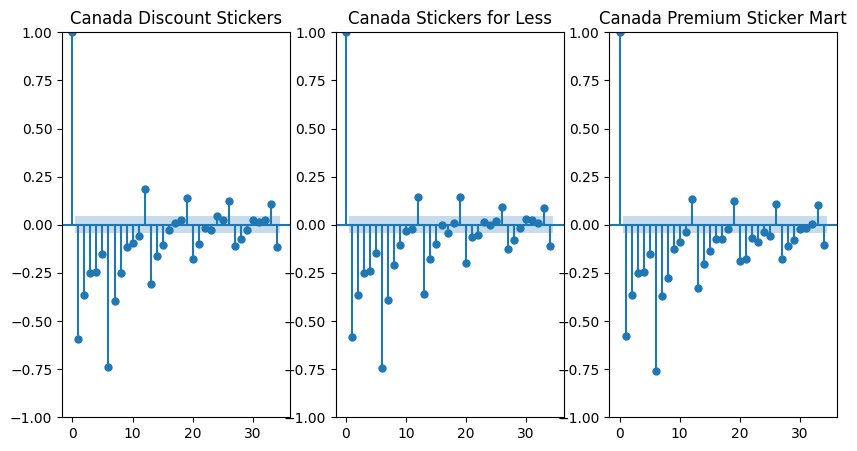

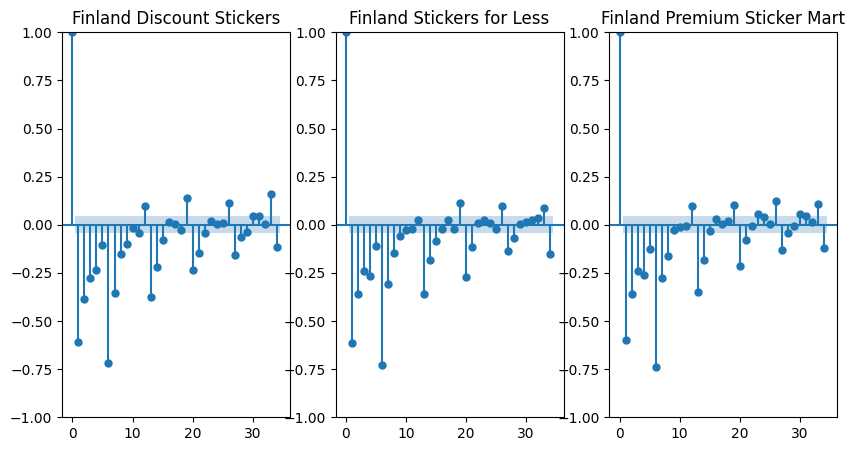

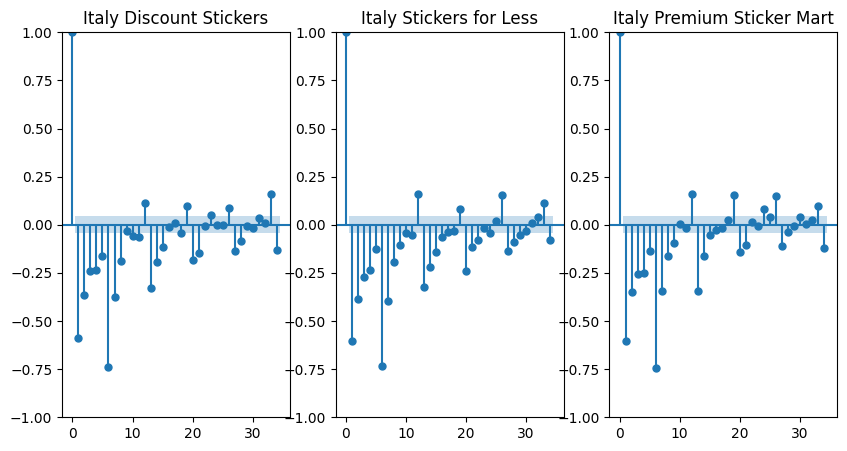

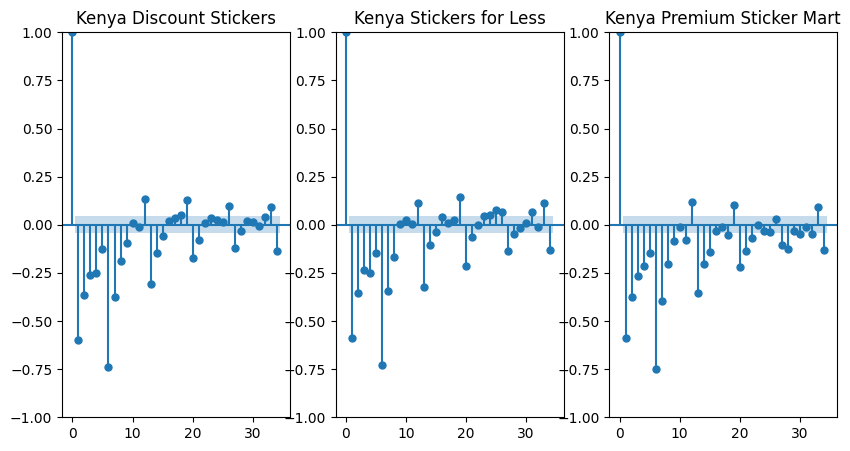

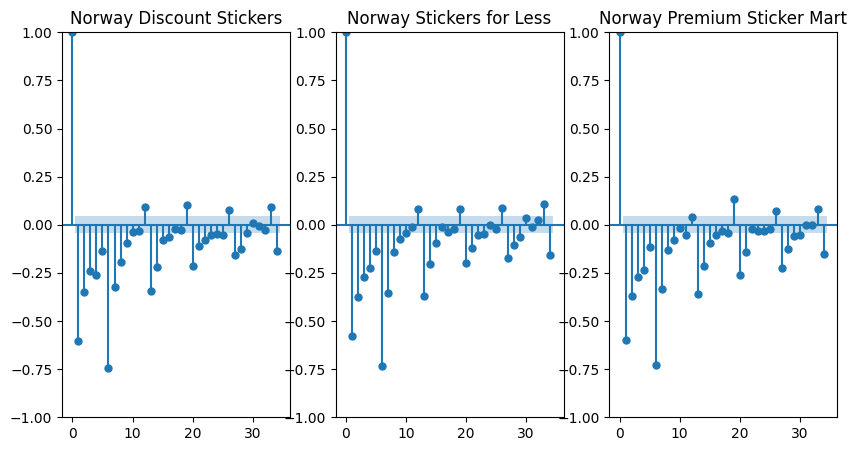

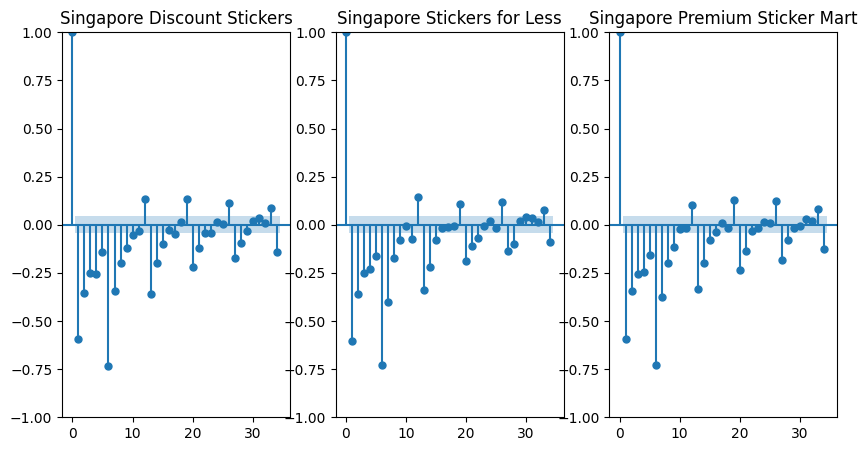

In [27]:
for country in train_kaggle.country.unique():
    fig, axes = plt.subplots(1, 3, sharex=True, figsize=(10, 5))
    i = 0
    for store in train_kaggle.store.unique():
        temp = train_df_kaggle.query('country == @country & store == @store')
        axes[i].set(ylim=(0,5))
        plot_pacf(temp.num_sold.diff().diff().dropna(), ax=axes[i])
        axes[i].set_title(country+' '+store)
        i+=1
    plt.show()

Видно, что достаточно взять порядок AR равный 1. Аналогично определим порядок MA части

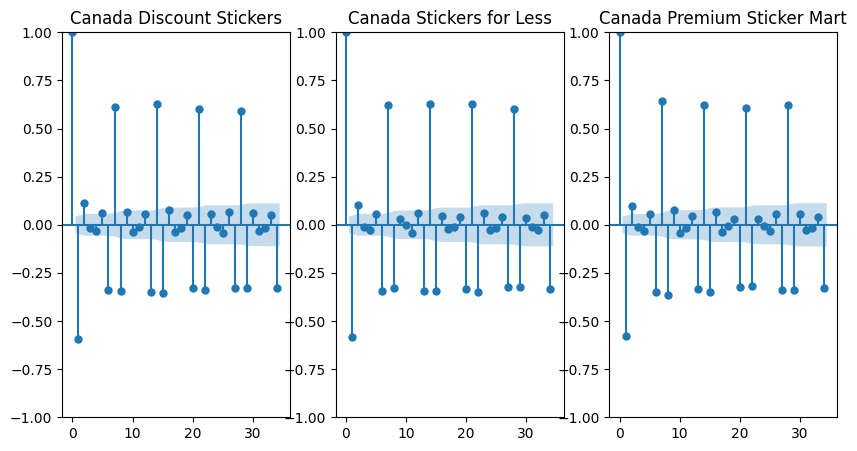

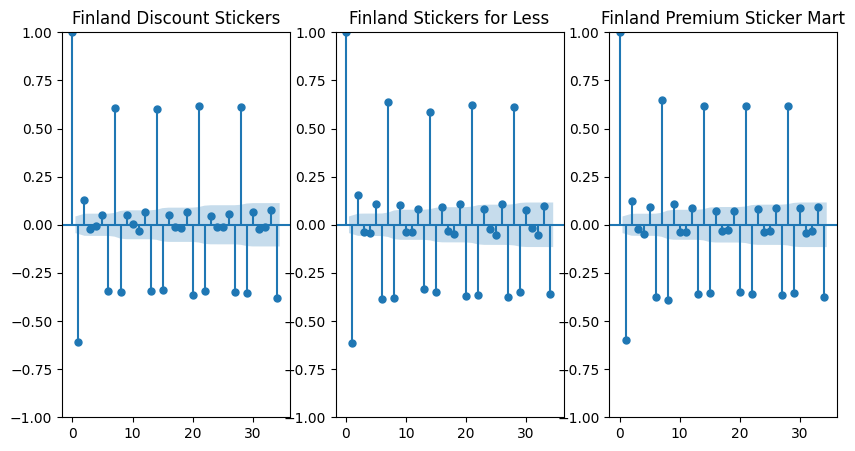

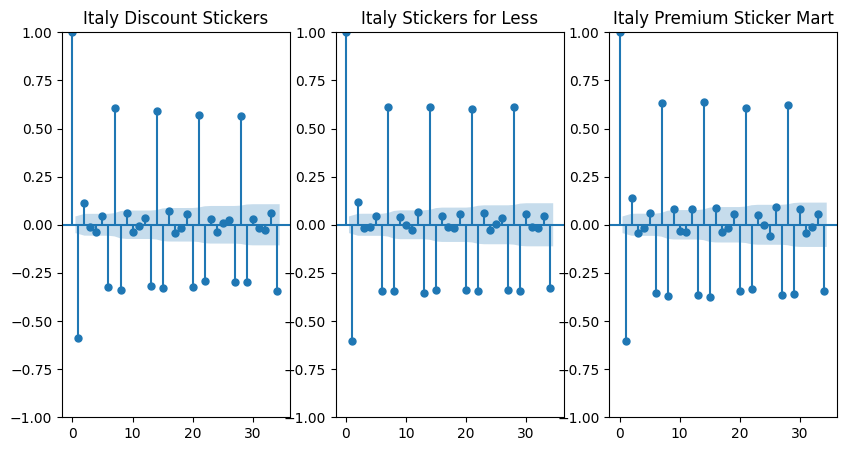

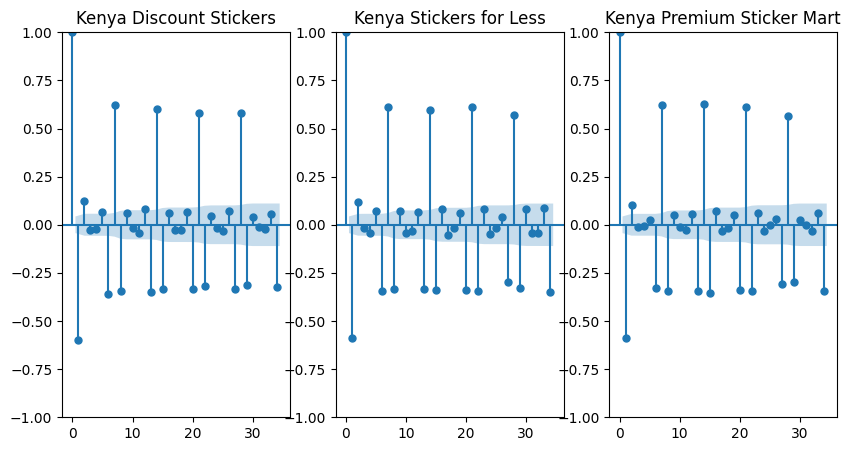

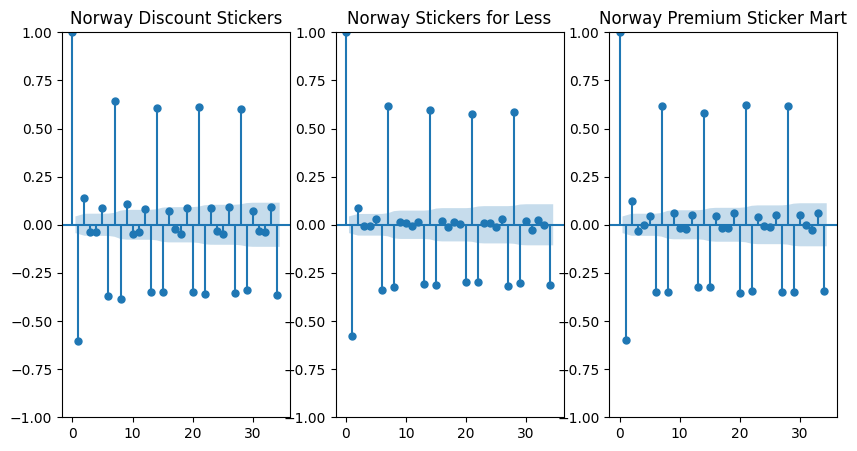

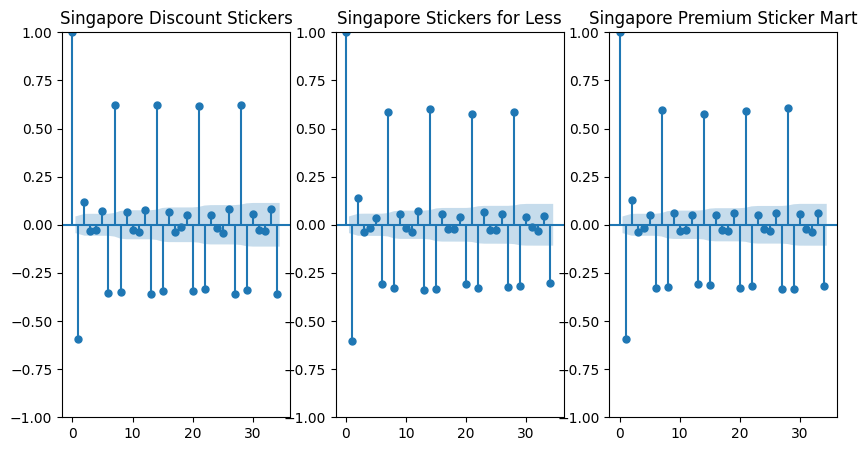

In [28]:
for country in train_kaggle.country.unique():
    fig, axes = plt.subplots(1, 3, sharex=True, figsize=(10, 5))
    i = 0
    for store in train_kaggle.store.unique():
        temp = train_df_kaggle.query('country == @country & store == @store')
        axes[i].set(ylim=(0,5))
        plot_acf(temp.num_sold.diff().diff().dropna(), ax=axes[i])
        axes[i].set_title(country+' '+store)
        i+=1
    plt.show()

Из полученных графиков следует, что надо взять MA = 1. В итоге получается модель ARIMA(1,2,1)

В визуализации явно видны сезонные колебания продаж, поэтому необходимо использовать SARIMA модель. Определим порядок сезонности

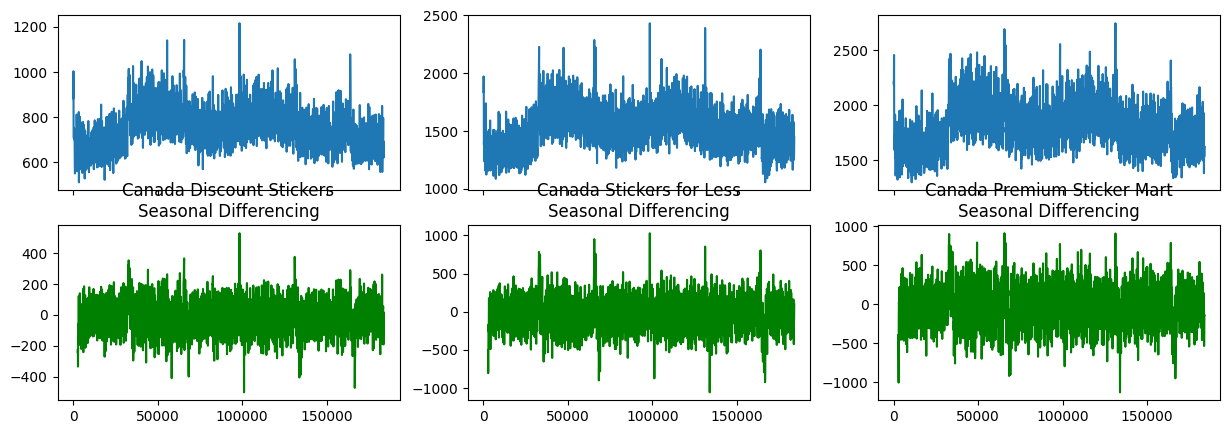

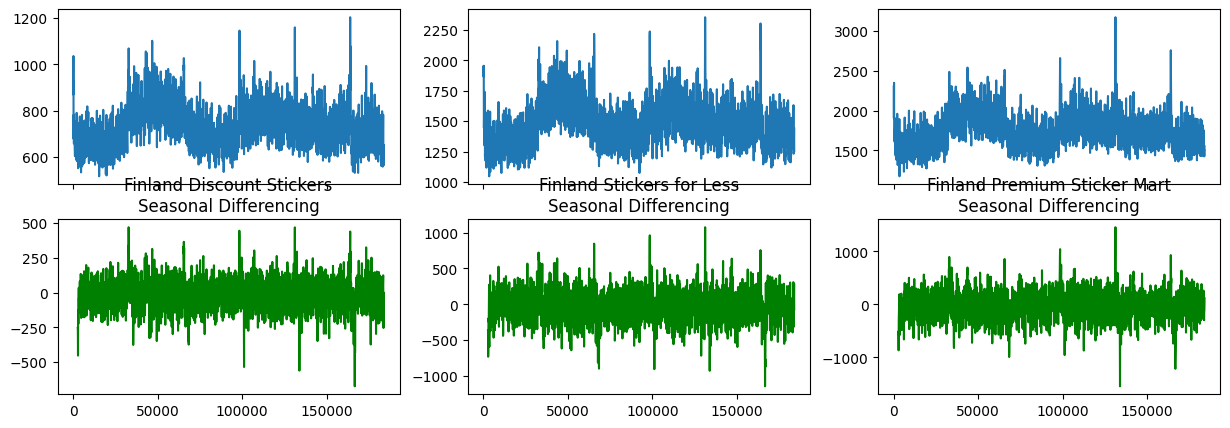

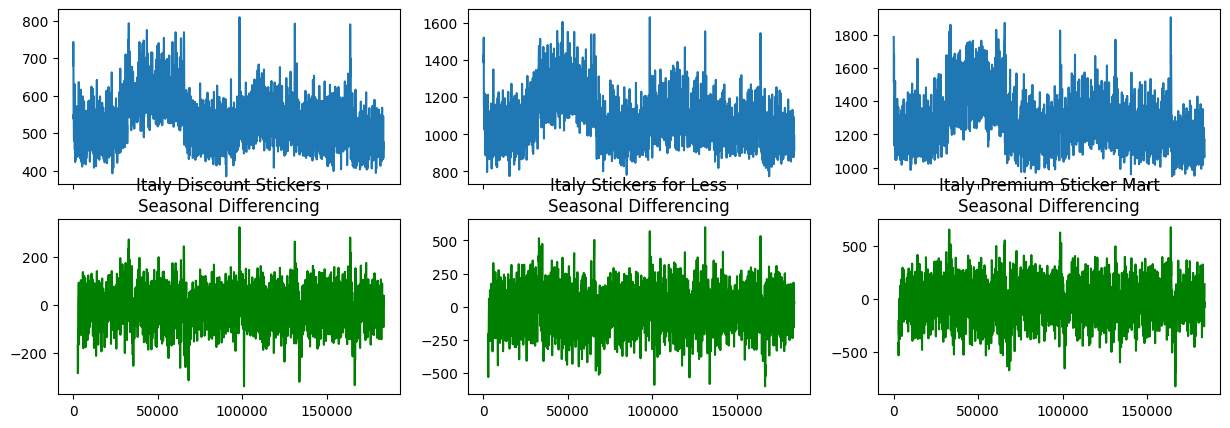

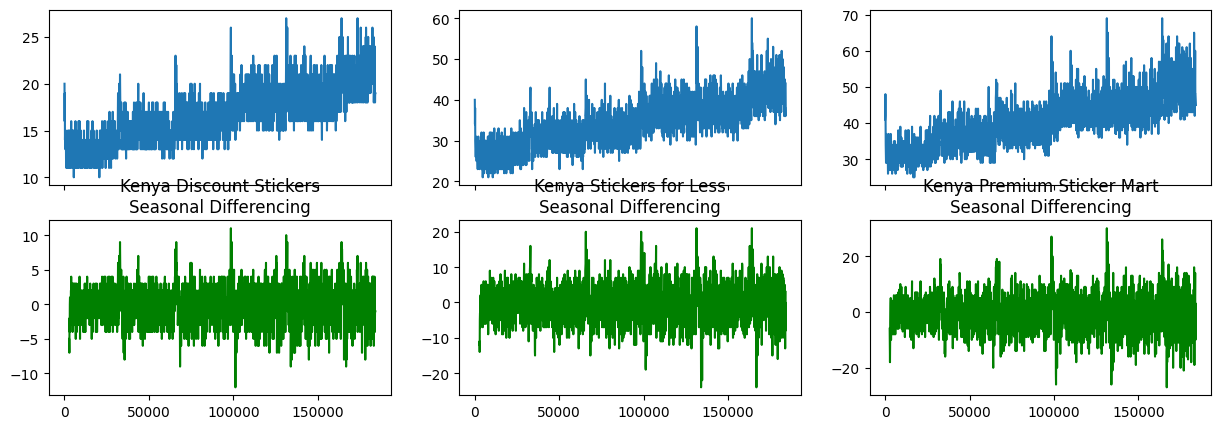

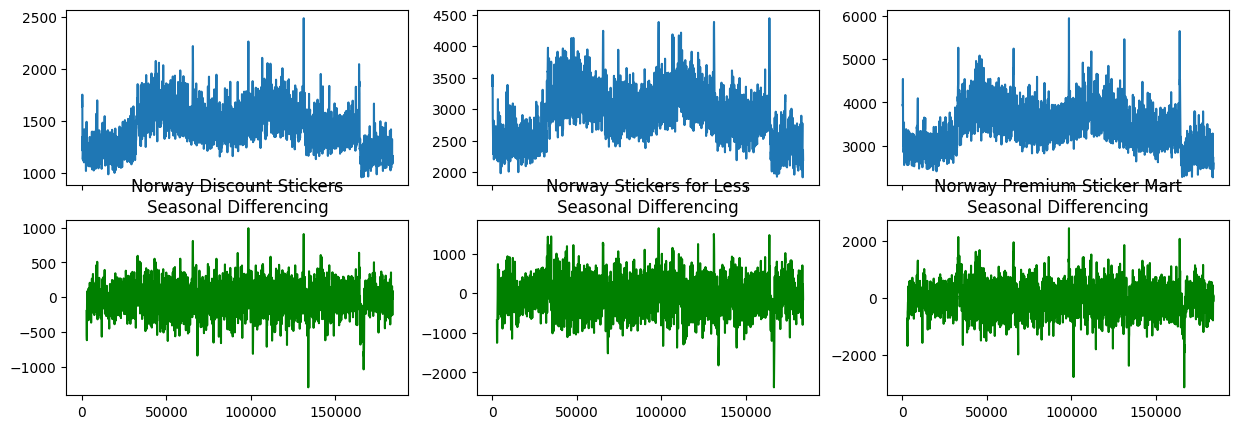

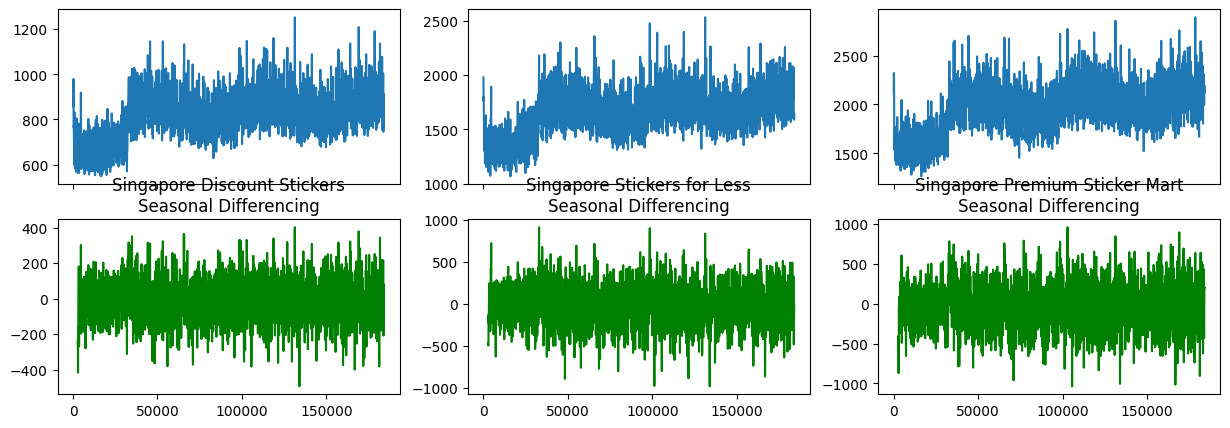

In [33]:
for country in train_df.country.unique():
    i = 0
    fig, axes = plt.subplots(2, 3, figsize=(15,5), dpi=100, sharex=True)
    for store in train_df.store.unique():
        temp = train_df_kaggle.query('country == @country & store == @store')
        axes[0, i//3].plot(temp.num_sold, label='Original Series')
        #Даты представлены днями, поэтому возьмём diff(30)
        axes[1, i//3].plot(temp.num_sold.diff(30), color='green')
        axes[1, i//3].set_title(country +' ' + store + '\nSeasonal Differencing')
        i+=3
    plt.show()

Получаем, что порядок сезонности равен 1, период 30

In [34]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

models = []
for country in train_kaggle.country.unique():
    for store in train_kaggle.store.unique():
        temp = train_kaggle.query('country == @country & store == @store')
        models.append(SARIMAX(temp.num_sold, seasonal_order=(1,2,1,30)))

                                      SARIMAX Results                                       
Dep. Variable:                             num_sold   No. Observations:                 2557
Model:             SARIMAX(1, 0, 0)x(1, 2, [1], 30)   Log Likelihood              -15017.325
Date:                              Thu, 09 Jan 2025   AIC                          30042.649
Time:                                      11:39:02   BIC                          30065.940
Sample:                                           0   HQIC                         30051.105
                                             - 2557                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3721      0.017     21.315      0.000       0.338       0.406
ar.S.L30      -0.42

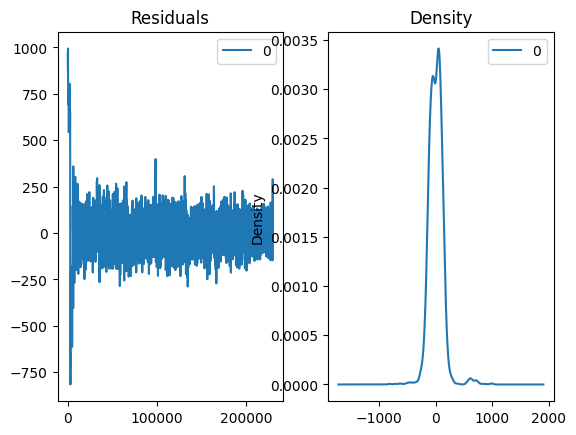

KeyboardInterrupt: 

In [35]:
for sarima in models:
    fit = sarima.fit()
    print(fit.summary())
    residuals = pd.DataFrame(fit.resid)
    fig, ax = plt.subplots(1,2)
    residuals.plot(title="Residuals", ax=ax[0])
    residuals.plot(kind='kde', title='Density', ax=ax[1])
    plt.show()


In [37]:
def create_train_valid(df):
    for country in train_kaggle.country.unique():
        plt.figure(figsize=(10, 5))
        for store in train_kaggle.store.unique():
            temp = train_kaggle.query('store == @store & country == @country')
            temp_train, temp_valid = train_test_split(temp, test_size=0.2, shuffle=False)
            train_df_kaggle, valid_df_kaggle = pd.concat([train_df_kaggle, temp_train]), pd.concat([valid_df_kaggle, temp_valid])
        sns.lineplot(data=train_df_kaggle.query('country == @country'), x='date', y='num_sold', hue='store')
        plt.title(country)
        plt.xticks(rotation=90)
        plt.show()
        print(kpss(temp.num_sold)[1], adfuller(temp.num_sold)[1])

In [39]:
train_df_kaggle_tiers, valid_df_kaggle_tiers = pd.DataFrame(), pd.DataFrame()
train_df_kerneller, valid_df_kerneller = pd.DataFrame(), pd.DataFrame()
train_df_kerneller_dm, valid_df_kerneller_dm = pd.DataFrame(), pd.DataFrame()
train_df_holographic_goose, valid_df_holographic_goose = pd.DataFrame, pd.DataFrame()

In [40]:
dict_df = {'train_df_kaggle':train_df_kaggle,'valid_df_kaggle':valid_df_kaggle,'train_df_kaggle_tiers':train_df_kaggle_tiers, \
           'valid_df_kaggle_tiers':valid_df_kaggle_tiers, 'train_df_kerneller':train_df_kerneller, 'valid_df_kerneller':valid_df_kerneller,\
          'train_df_kerneller_dm':train_df_kerneller_dm,'valid_df_kerneller_dm':valid_df_kerneller_dm,'train_df_holographic_goose':train_df_holographic_goose,\
          'valid_df_holographic_goose':valid_df_holographic_goose}

In [36]:
def create_SARIMA_models(df):
    for country in train_kaggle.country.unique():
        fig, axes = plt.subplots(4, 3, sharex=True, figsize=(12, 12))
        i = 0
        for store in train_kaggle.store.unique():
            temp = train_df_kaggle.query('country == @country & store == @store')
            # Original Series
            plot_acf(temp.num_sold, ax=axes[0, i//3], title=country + store +' d=0')
            
            # 1st Differencing
            plot_acf(temp.num_sold.diff().dropna(), ax=axes[1, i//3], title=country + store +' d=1')
            
            # 2nd Differencing
            plot_acf(temp.num_sold.diff().diff().dropna(), ax=axes[2, i//3], title=country + store +' d=2')
        
            # 3nd Differencing
            plot_acf(temp.num_sold.diff().diff().diff().dropna(), ax=axes[3,i//3], title=country + store +' d=3')
            i += 3
        plt.show()
    for country in train_kaggle.country.unique():
        fig, axes = plt.subplots(1, 3, sharex=True, figsize=(10, 5))
        i = 0
        for store in train_kaggle.store.unique():
            temp = train_df_kaggle.query('country == @country & store == @store')
            axes[i].set(ylim=(0,5))
            plot_pacf(temp.num_sold.diff().diff().dropna(), ax=axes[i])
            axes[i].set_title(country+' '+store)
            i+=1
        plt.show()
    for country in train_kaggle.country.unique():
        fig, axes = plt.subplots(1, 3, sharex=True, figsize=(10, 5))
        i = 0
        for store in train_kaggle.store.unique():
            temp = train_df_kaggle.query('country == @country & store == @store')
            axes[i].set(ylim=(0,5))
            plot_acf(temp.num_sold.diff().diff().dropna(), ax=axes[i])
            axes[i].set_title(country+' '+store)
            i+=1
        plt.show()
    for country in train_df.country.unique():
        i = 0
        fig, axes = plt.subplots(2, 3, figsize=(15,5), dpi=100, sharex=True)
        for store in train_df.store.unique():
            temp = train_df_kaggle.query('country == @country & store == @store')
            axes[0, i//3].plot(temp.num_sold, label='Original Series')
            #Даты представлены днями, поэтому возьмём diff(30)
            axes[1, i//3].plot(temp.num_sold.diff(30), color='green')
            axes[1, i//3].set_title(country +' ' + store + '\nSeasonal Differencing')
            i+=3
        plt.show()

IndentationError: expected an indented block after 'for' statement on line 2 (<ipython-input-36-9f7a0039ccde>, line 3)